In [15]:
# Komórka 1 – wczytywanie plików z katalogu data/pomiary_finalne

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

plt.rcParams["figure.figsize"] = (10, 4)

BASELINE_LEN_S   = 0.5
SMOOTH_LEN_S     = 0.05
STD_THRESHOLD    = 3.0
DELAY_AFTER_JUMP = 1.0
WINDOW_LEN_S     = 12.0

LSB_TO_G = 0.0039

# <<< WAŻNE: relative path od notebooka >>>
BASE = Path("data/pomiary_finalne")

MATERIAL_DIRS = {
    "kupione":          "kupione_smiglo",
    "kupione_otwor":    "kupione_otwór",   # zmień na "kupione_otwor" jeśli katalog jest bez ó
}

PWM_DIRS = ["pwm_20%", "pwm_30%", "pwm_40%", "pwm_50%"]


def load_xyz_from_csv(path):
    df = pd.read_csv(path)
    cols_lower = {c.lower(): c for c in df.columns}

    time_col = None
    for key, orig in cols_lower.items():
        if "time" in key or "czas" in key:
            time_col = orig
            break

    x_col = y_col = z_col = None
    for key, orig in cols_lower.items():
        if x_col is None and key.startswith("x"):
            x_col = orig
        if y_col is None and key.startswith("y"):
            y_col = orig
        if z_col is None and key.startswith("z"):
            z_col = orig

    if time_col is None or x_col is None or y_col is None or z_col is None:
        raise ValueError(
            f"Nie mogę automatycznie znaleźć kolumn w pliku {path}.\n"
            f"Znalezione kolumny: {df.columns.tolist()}"
        )

    t  = df[time_col].to_numpy()
    ax = df[x_col].to_numpy() * LSB_TO_G
    ay = df[y_col].to_numpy() * LSB_TO_G
    az = df[z_col].to_numpy() * LSB_TO_G

    dt = np.mean(np.diff(t))
    Fs = 1.0 / dt
    return t, ax, ay, az, Fs


def detect_steady_window(
    t, ax, ay, az,
    baseline_len_s=BASELINE_LEN_S,
    smooth_len_s=SMOOTH_LEN_S,
    std_threshold=STD_THRESHOLD,
    delay_after_jump=DELAY_AFTER_JUMP,
    window_len_s=WINDOW_LEN_S,
):
    mag = np.sqrt(ax**2 + ay**2 + az**2)

    t0 = t[0]
    baseline_mask = t <= (t0 + baseline_len_s)
    baseline = mag[baseline_mask]
    mu = baseline.mean()
    sigma = baseline.std()
    thresh = mu + std_threshold * sigma

    dt = np.mean(np.diff(t))
    Fs = 1.0 / dt
    win_samples = int(round(smooth_len_s * Fs))
    if win_samples < 1:
        win_samples = 1
    kernel = np.ones(win_samples) / win_samples
    mag_smooth = np.convolve(mag, kernel, mode="same")

    idx_candidates = np.where(mag_smooth > thresh)[0]
    if len(idx_candidates) == 0:
        t_start = t0 + 1.0
    else:
        idx_event = idx_candidates[0]
        t_event = t[idx_event]
        t_start = t_event + delay_after_jump

    t_end = t_start + window_len_s
    if t_end > t[-1]:
        t_end = t[-1]
        t_start = t_end - window_len_s
        if t_start < t0:
            t_start = t0

    mask_seg = (t >= t_start) & (t <= t_end)

    return (
        t[mask_seg],
        ax[mask_seg],
        ay[mask_seg],
        az[mask_seg],
        (t_start, t_end),
        mag,
        mag_smooth,
        thresh,
    )


file_entries = []
for mat_label, mat_dir_name in MATERIAL_DIRS.items():
    for pwm_dir in PWM_DIRS:
        dir_path = BASE / mat_dir_name / pwm_dir
        if not dir_path.exists():
            continue
        for csv_path in sorted(dir_path.glob("*.csv")):
            stem = csv_path.stem
            try:
                rep = int(stem.split("_")[0])
            except ValueError:
                rep = None

            pwm_val = int(pwm_dir.replace("pwm_", "").replace("%", ""))

            file_entries.append({
                "path": csv_path,
                "file_id": str(csv_path),
                "material": mat_label,
                "pwm": pwm_val,
                "rep": rep,
            })

files_df = pd.DataFrame(file_entries)
print(f"Znaleziono {len(files_df)} plików:")
display(files_df)


Znaleziono 40 plików:


,path,file_id,material,pwm,rep
0,data\pomiary_finalne\kupione_smiglo\pwm_20%\1_...,data\pomiary_finalne\kupione_smiglo\pwm_20%\1_...,kupione,20,1
1,data\pomiary_finalne\kupione_smiglo\pwm_20%\2_...,data\pomiary_finalne\kupione_smiglo\pwm_20%\2_...,kupione,20,2
2,data\pomiary_finalne\kupione_smiglo\pwm_20%\3_...,data\pomiary_finalne\kupione_smiglo\pwm_20%\3_...,kupione,20,3
3,data\pomiary_finalne\kupione_smiglo\pwm_20%\4_...,data\pomiary_finalne\kupione_smiglo\pwm_20%\4_...,kupione,20,4
4,data\pomiary_finalne\kupione_smiglo\pwm_20%\5_...,data\pomiary_finalne\kupione_smiglo\pwm_20%\5_...,kupione,20,5
5,data\pomiary_finalne\kupione_smiglo\pwm_30%\1_...,data\pomiary_finalne\kupione_smiglo\pwm_30%\1_...,kupione,30,1
6,data\pomiary_finalne\kupione_smiglo\pwm_30%\2_...,data\pomiary_finalne\kupione_smiglo\pwm_30%\2_...,kupione,30,2
7,data\pomiary_finalne\kupione_smiglo\pwm_30%\3_...,data\pomiary_finalne\kupione_smiglo\pwm_30%\3_...,kupione,30,3
8,data\pomiary_finalne\kupione_smiglo\pwm_30%\4_...,data\pomiary_finalne\kupione_smiglo\pwm_30%\4_...,kupione,30,4
9,data\pomiary_finalne\kupione_smiglo\pwm_30%\5_...,data\pomiary_finalne\kupione_smiglo\pwm_30%\5_...,kupione,30,5


In [ ]:
# Komórka 2 – pomocnicza: wycinanie segmentów ustalonej pracy

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)

pwm_values = [20, 30, 40, 50]


def compute_segments_for_selection(selection_df):
    """
    Dla jednego materiału i jednego PWM zwraca listę segmentów.
    Używamy później wyłącznie osi Y (ay).
    """
    segments = []
    for _, row in selection_df.iterrows():
        t, ax, ay, az, Fs = load_xyz_from_csv(row["path"])
        (
            t_seg, ax_seg, ay_seg, az_seg,
            (t_start, t_end), mag, mag_smooth, thresh
        ) = detect_steady_window(t, ax, ay, az)

        segments.append({
            "Fs": Fs,
            "t": t_seg,
            "ay": ay_seg,      # oś Y
            "meta": row,
            "t_start": t_start,
            "t_end": t_end,
        })
    return segments


In [20]:
# Komórka 2 – pomocnicza: wycinanie segmentów ustalonej pracy

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)

pwm_values = [20, 30, 40, 50]


def compute_segments_for_selection(selection_df):
    """
    Dla jednego materiału i jednego PWM zwraca listę segmentów.
    Używamy później wyłącznie osi Y (ay).
    """
    segments = []
    for _, row in selection_df.iterrows():
        t, ax, ay, az, Fs = load_xyz_from_csv(row["path"])
        (
            t_seg, ax_seg, ay_seg, az_seg,
            (t_start, t_end), mag, mag_smooth, thresh
        ) = detect_steady_window(t, ax, ay, az)

        segments.append({
            "Fs": Fs,
            "t": t_seg,
            "ay": ay_seg,      # oś Y
            "meta": row,
            "t_start": t_start,
            "t_end": t_end,
        })
    return segments


C:\Users\szymo\AppData\Local\Temp\ipykernel_19860\1966860386.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.97])


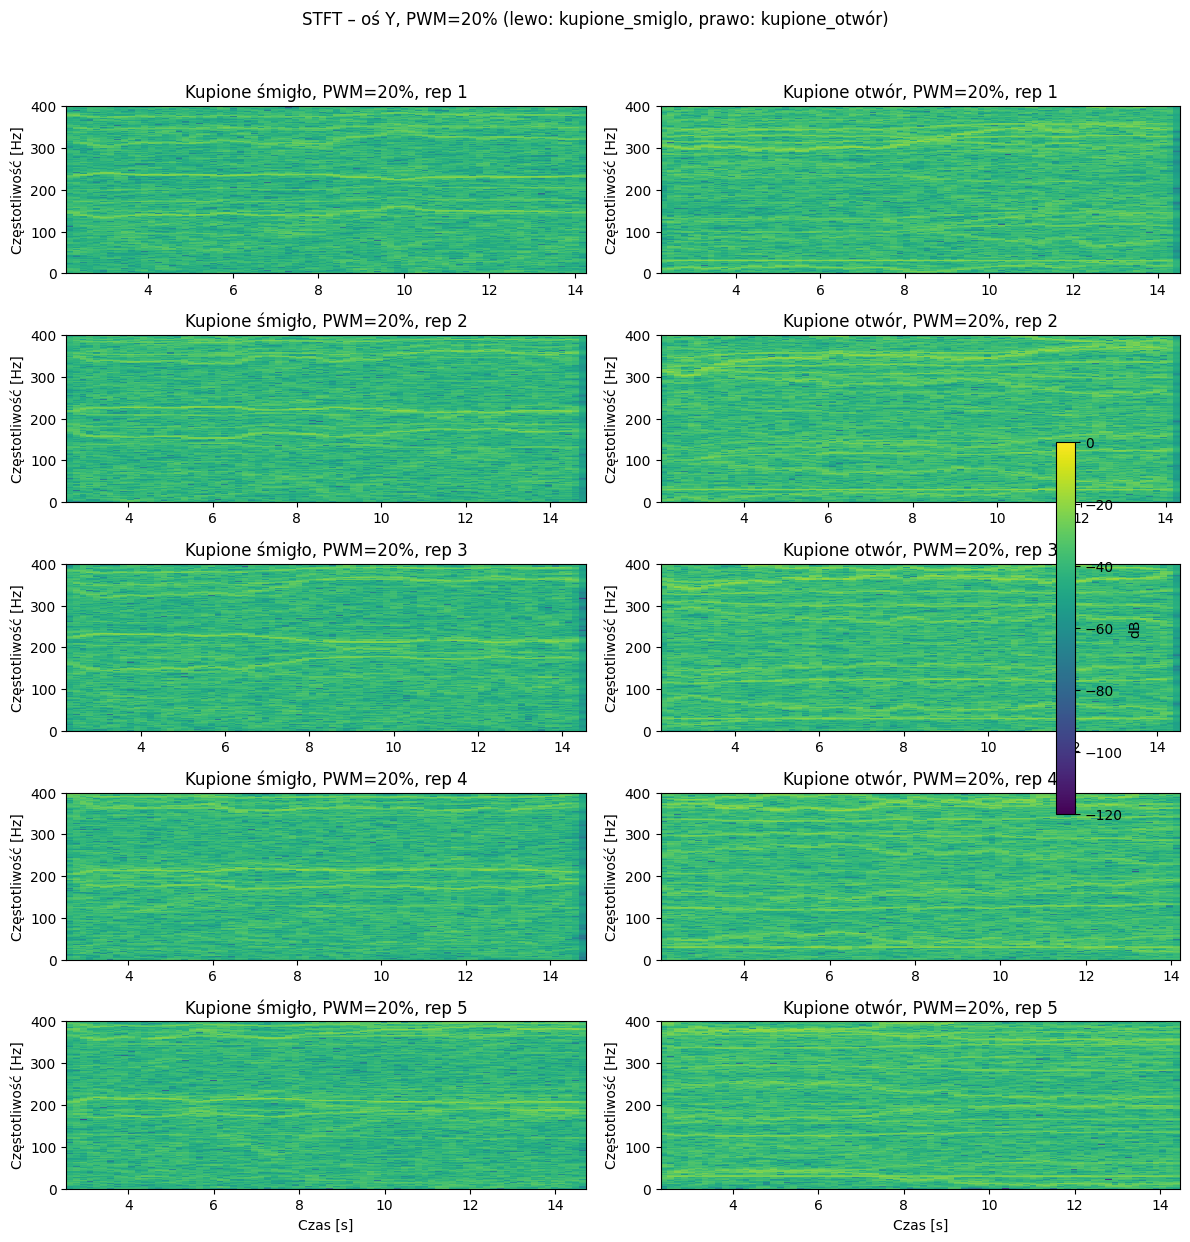

C:\Users\szymo\AppData\Local\Temp\ipykernel_19860\1966860386.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.97])


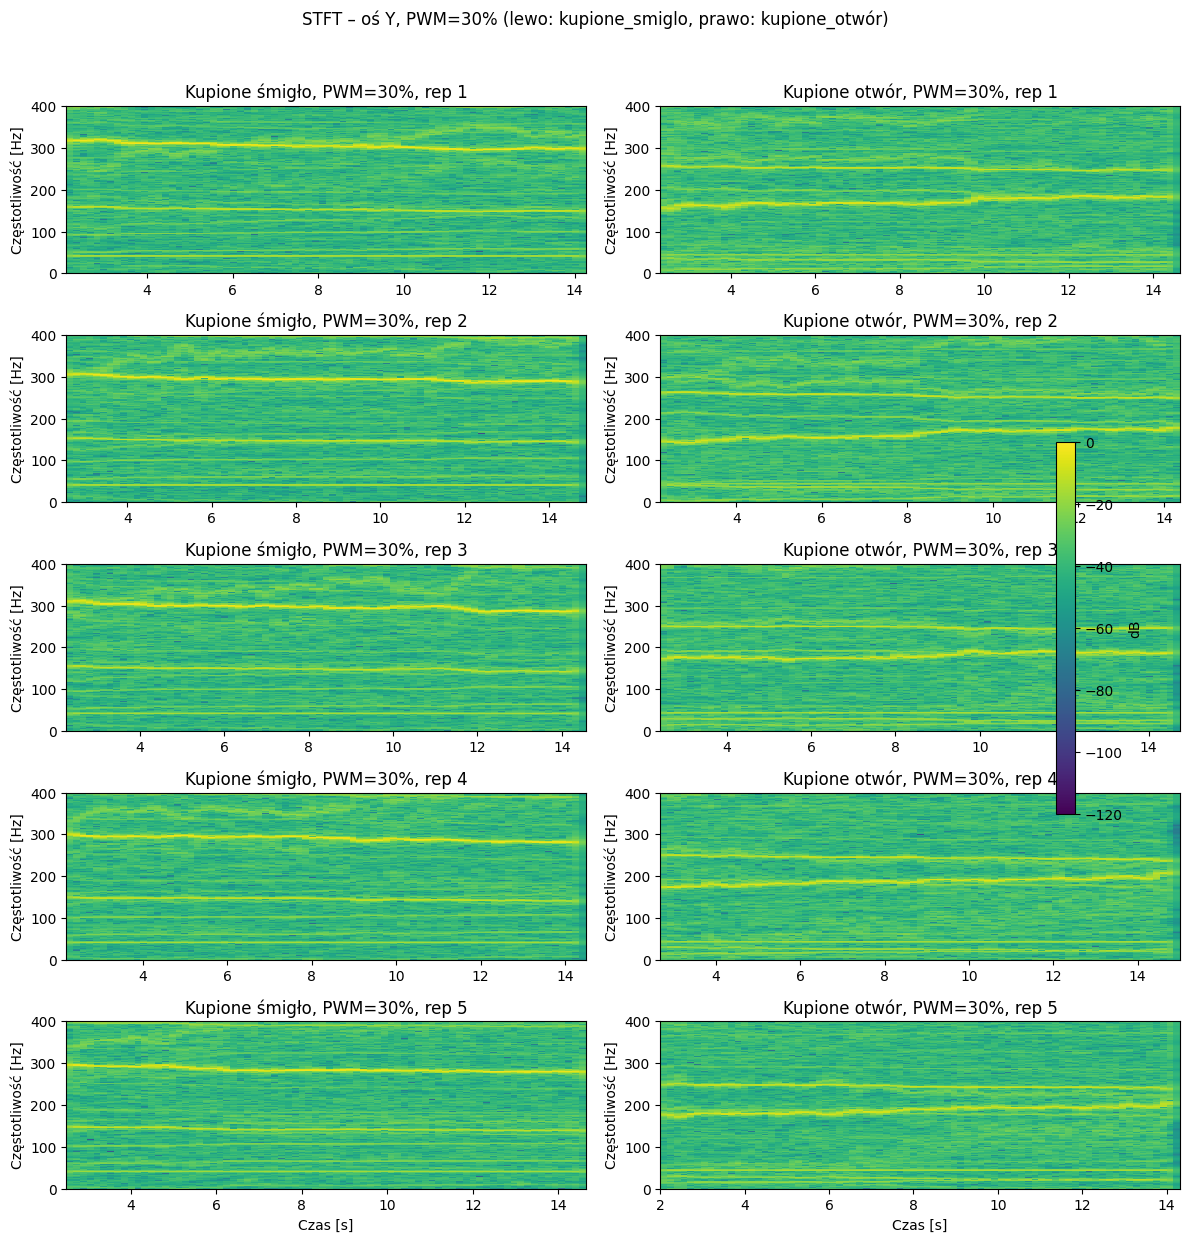

C:\Users\szymo\AppData\Local\Temp\ipykernel_19860\1966860386.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.97])


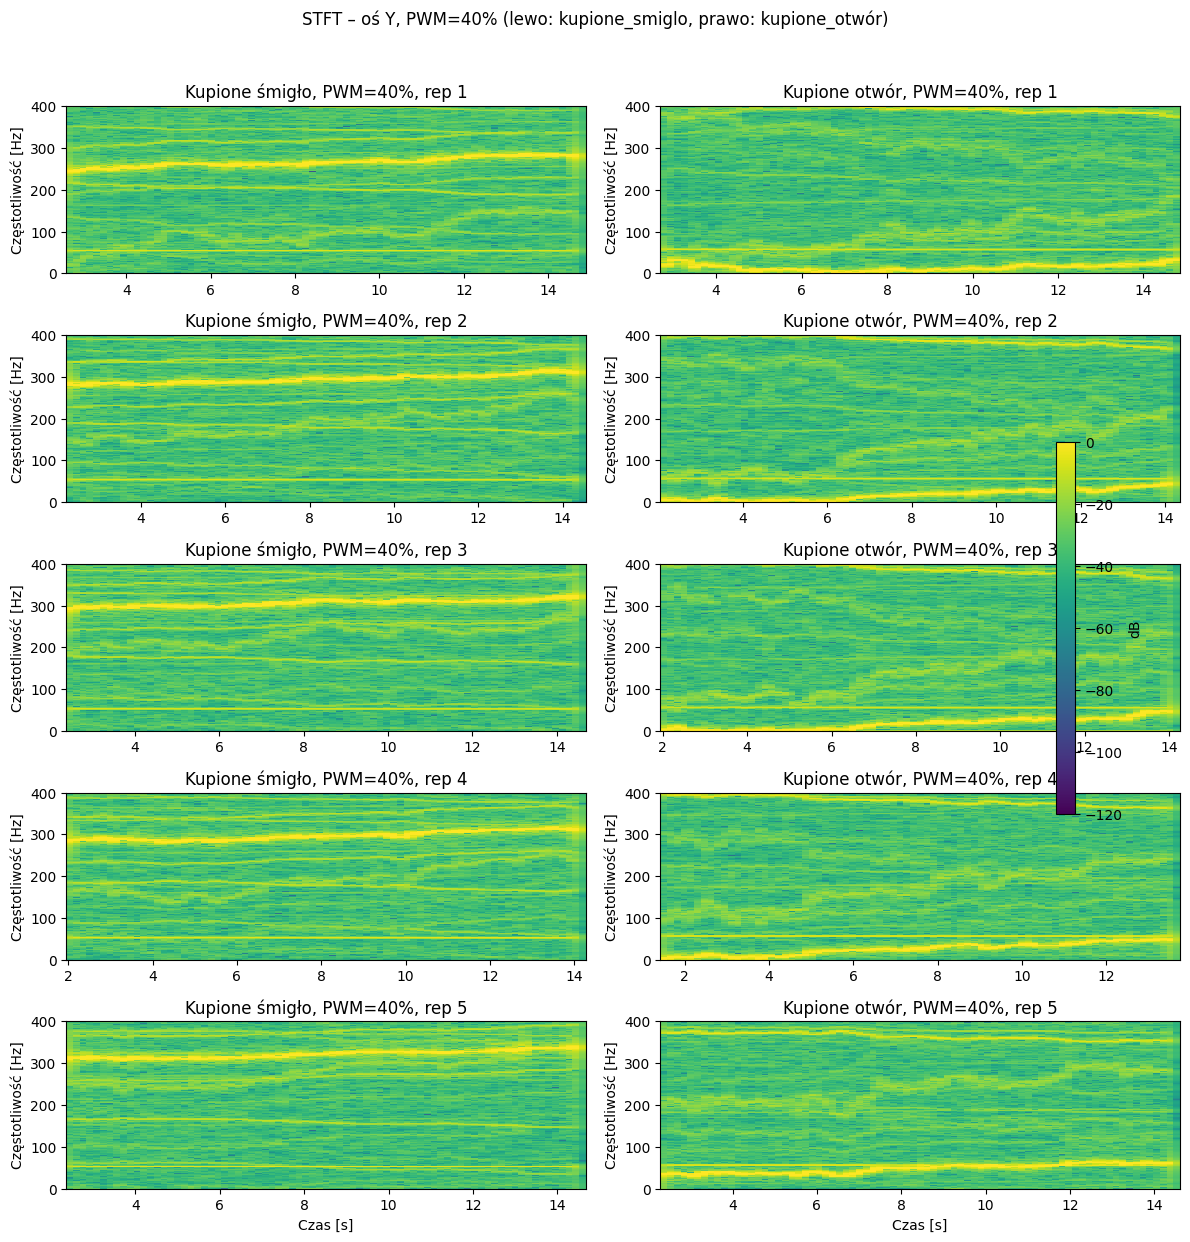

C:\Users\szymo\AppData\Local\Temp\ipykernel_19860\1966860386.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.97])


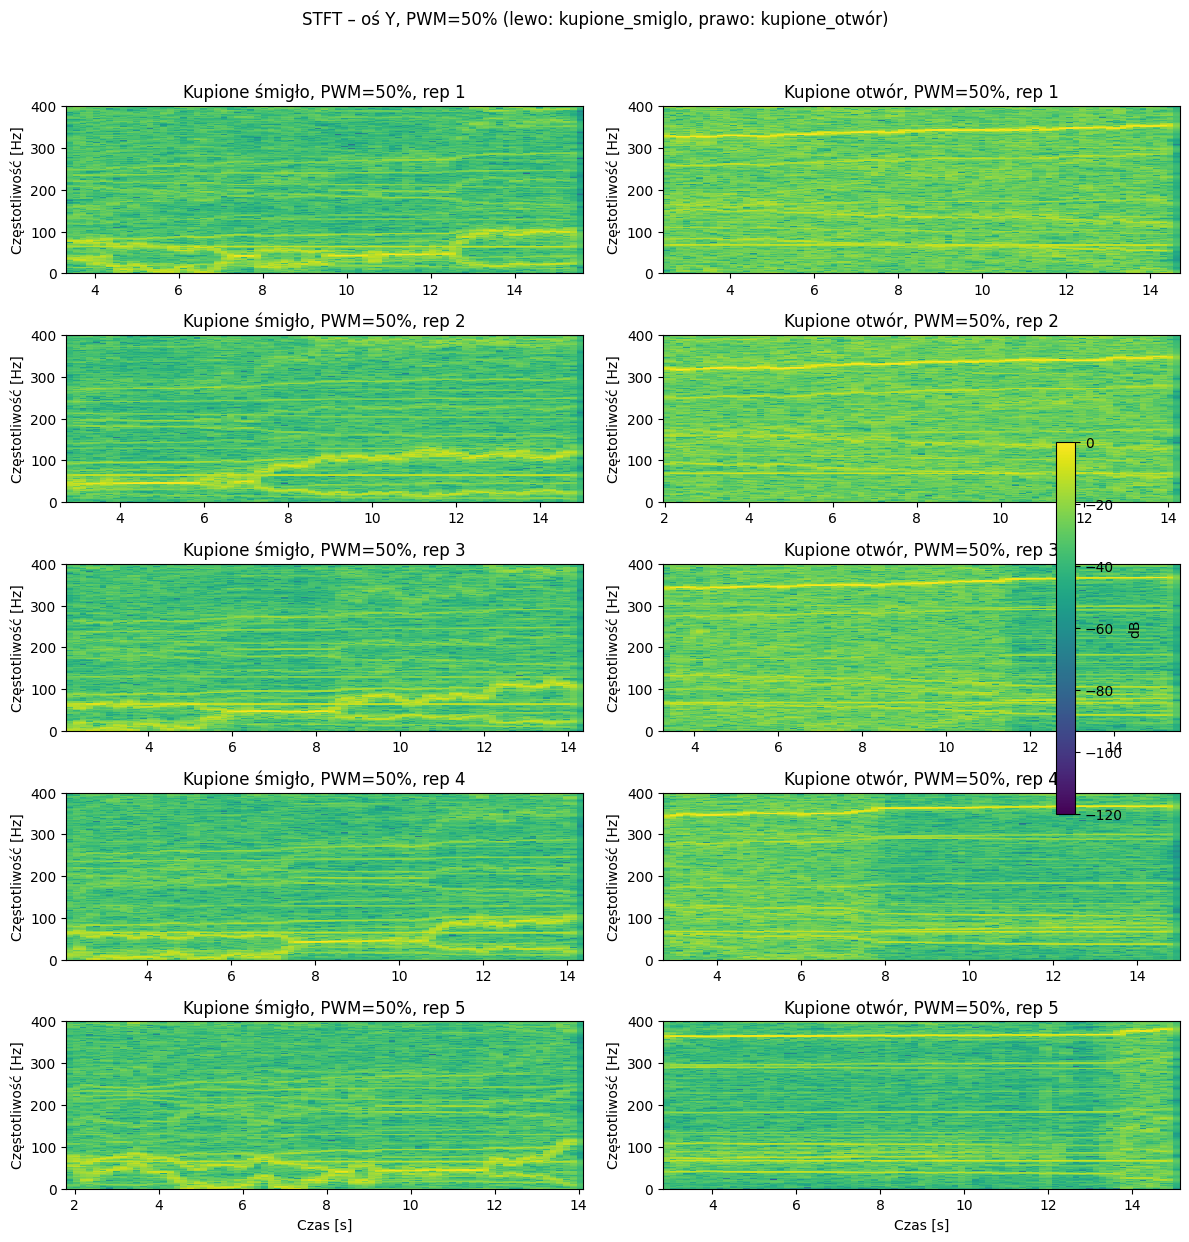

In [22]:
# Komórka 3 – STFT porównanie: kupione_smiglo vs kupione_otwór (oś Y, do 800 Hz)

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

plt.rcParams["figure.figsize"] = (12, 4)

pwm_values = [20, 30, 40, 50]

for pwm in pwm_values:
    kup = files_df[
        (files_df["material"] == "kupione") &
        (files_df["pwm"] == pwm)
    ].sort_values("rep")

    kup_otw = files_df[
        (files_df["material"] == "kupione_otwor") &
        (files_df["pwm"] == pwm)
    ].sort_values("rep")

    if kup.empty or kup_otw.empty:
        print(f"Brak kompletu danych dla PWM={pwm}%")
        continue

    # wspólne numery powtórzeń – u Ciebie powinno być 1..5
    common_reps = sorted(set(kup["rep"].dropna()) & set(kup_otw["rep"].dropna()))
    if not common_reps:
        print(f"Brak wspólnych rep dla PWM={pwm}%")
        continue

    n_reps = len(common_reps)   # spodziewane 5

    fig, axes = plt.subplots(
        n_reps, 2,
        figsize=(12, 2.5 * n_reps),
        squeeze=False
    )

    last_im = None

    for row_idx, rep in enumerate(common_reps):
        # ---------- LEWO: kupione_smiglo ----------
        row_k = kup[kup["rep"] == rep].iloc[0]
        t_k, ax_k, ay_k, az_k, Fs_k = load_xyz_from_csv(row_k["path"])
        (
            t_seg_k, ax_seg_k, ay_seg_k, az_seg_k,
            (t_start_k, t_end_k), mag_k, mag_smooth_k, thresh_k
        ) = detect_steady_window(t_k, ax_k, ay_k, az_k)

        # OŚ Y:
        y_k = ay_seg_k - ay_seg_k.mean()
        f_k, tt_k, Z_k = stft(
            y_k, fs=Fs_k, window="hann",
            nperseg=1024, noverlap=768
        )
        Zk_db = 20 * np.log10(np.abs(Z_k) + 1e-12)

        ax_left = axes[row_idx, 0]
        im = ax_left.pcolormesh(
            tt_k + t_seg_k[0], f_k, Zk_db,
            shading="auto", vmin=-120, vmax=0
        )
        last_im = im
        ax_left.set_ylim(0, 400)
        if row_idx == n_reps - 1:
            ax_left.set_xlabel("Czas [s]")
        ax_left.set_ylabel("Częstotliwość [Hz]")
        ax_left.set_title(f"Kupione śmigło, PWM={pwm}%, rep {rep}")

        # ---------- PRAWO: kupione_otwór ----------
        row_o = kup_otw[kup_otw["rep"] == rep].iloc[0]
        t_o, ax_o, ay_o, az_o, Fs_o = load_xyz_from_csv(row_o["path"])
        (
            t_seg_o, ax_seg_o, ay_seg_o, az_seg_o,
            (t_start_o, t_end_o), mag_o, mag_smooth_o, thresh_o
        ) = detect_steady_window(t_o, ax_o, ay_o, az_o)

        y_o = ay_seg_o - ay_seg_o.mean()
        f_o, tt_o, Z_o = stft(
            y_o, fs=Fs_o, window="hann",
            nperseg=1024, noverlap=768
        )
        Zo_db = 20 * np.log10(np.abs(Z_o) + 1e-12)

        ax_right = axes[row_idx, 1]
        im = ax_right.pcolormesh(
            tt_o + t_seg_o[0], f_o, Zo_db,
            shading="auto", vmin=-120, vmax=0
        )
        last_im = im
        ax_right.set_ylim(0, 400)
        if row_idx == n_reps - 1:
            ax_right.set_xlabel("Czas [s]")
        ax_right.set_ylabel("Częstotliwość [Hz]")
        ax_right.set_title(f"Kupione otwór, PWM={pwm}%, rep {rep}")

    if last_im is not None:
        fig.colorbar(
            last_im,
            ax=axes[:, 0].tolist() + axes[:, 1].tolist(),
            label="dB",
            fraction=0.02,
            pad=0.02
        )

    fig.suptitle(
        f"STFT – oś Y, PWM={pwm}% (lewo: kupione_smiglo, prawo: kupione_otwór)",
        y=0.99
    )
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
